In [1]:
import os
import time
import sys
sys.path.append("../")
from data_utils.load_data import load_dataset
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torch.nn as nn



TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()


Length of Text Vocabulary: 251639
Vector size of Text Vocabulary:  torch.Size([251639, 300])
Label Length: 2


In [2]:
# selfAttention模型


class SelfAttention(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(SelfAttention, self).__init__()

		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		--------
		
		"""

		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		self.weights = weights

		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
		self.dropout = 0.8
		self.bilstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
		# We will use da = 350, r = 30 & penalization_coeff = 1 as per given in the self-attention original ICLR paper
		self.W_s1 = nn.Linear(2*hidden_size, 350)
		self.W_s2 = nn.Linear(350, 30)
		self.fc_layer = nn.Linear(30*2*hidden_size, 2000)
		self.label = nn.Linear(2000, output_size)

	def attention_net(self, lstm_output):

		"""
		Now we will use self attention mechanism to produce a matrix embedding of the input sentence in which every row represents an
		encoding of the inout sentence but giving an attention to a specific part of the sentence. We will use 30 such embedding of 
		the input sentence and then finally we will concatenate all the 30 sentence embedding vectors and connect it to a fully 
		connected layer of size 2000 which will be connected to the output layer of size 2 returning logits for our two classes i.e., 
		pos & neg.

		Arguments
		---------

		lstm_output = A tensor containing hidden states corresponding to each time step of the LSTM network.
		---------

		Returns : Final Attention weight matrix for all the 30 different sentence embedding in which each of 30 embeddings give
				  attention to different parts of the input sentence.

		Tensor size : lstm_output.size() = (batch_size, num_seq, 2*hidden_size)
					  attn_weight_matrix.size() = (batch_size, 30, num_seq)

		"""
		attn_weight_matrix = self.W_s2(F.tanh(self.W_s1(lstm_output)))
		attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
		attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)

		return attn_weight_matrix

	def forward(self, input_sentences, batch_size=None):

		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for pos & neg class.
		
		"""

		input = self.word_embeddings(input_sentences)
		input = input.permute(1, 0, 2)
		if batch_size is None:
			h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
		else:
			h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

		output, (h_n, c_n) = self.bilstm(input, (h_0, c_0))
		output = output.permute(1, 0, 2)
		# output.size() = (batch_size, num_seq, 2*hidden_size)
		# h_n.size() = (1, batch_size, hidden_size)
		# c_n.size() = (1, batch_size, hidden_size)
		attn_weight_matrix = self.attention_net(output)
		# attn_weight_matrix.size() = (batch_size, r, num_seq)
		# output.size() = (batch_size, num_seq, 2*hidden_size)
		hidden_matrix = torch.bmm(attn_weight_matrix, output)
		# hidden_matrix.size() = (batch_size, r, 2*hidden_size)
		# Let's now concatenate the hidden_matrix and connect it to the fully connected layer.
		fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
		logits = self.label(fc_out)
		# logits.size() = (batch_size, output_size)

		return logits

In [3]:
learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 300

model = SelfAttention(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
loss_fn = F.cross_entropy

/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [4]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] != 32):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        # if steps % 100 == 0:
        #     print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] != 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)
	

In [5]:
losses = []
accuracies = []
eval_accuracies = []
test_accuracies = []
temp_Acc = 0
total_epoch = 10
file_path = './models/best_self_Attention.pth'
for epoch in range(total_epoch):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc = eval_model(model, valid_iter)
    test_loss, test_acc = eval_model(model, test_iter)
    losses.append(train_loss)
    accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    eval_accuracies.append(val_acc)
    # print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%,  Val. Acc: {val_acc:.2f}%')
    if test_acc>temp_Acc:
        temp_Acc = test_acc
        if os.path.exists(file_path):
            # 删除文件
            os.remove(file_path)
        torch.save(model.state_dict(),file_path )
import matplotlib.pyplot as plt


epochs = range(1, total_epoch+1)


/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


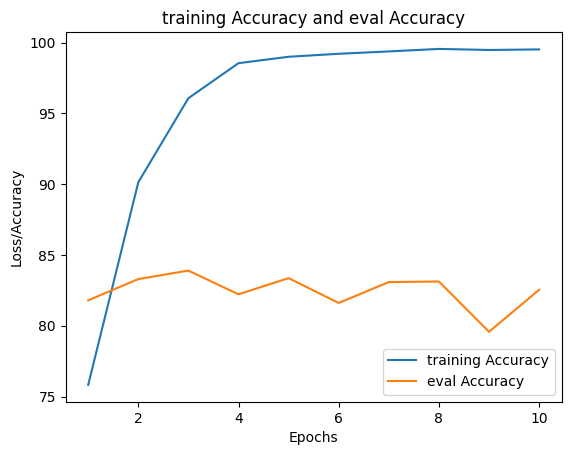

In [6]:
# 绘制损失-轮次图表
plt.plot(epochs, accuracies, label='training Accuracy')
plt.plot(epochs, eval_accuracies, label='eval Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('training Accuracy and eval Accuracy')
plt.legend()
plt.show()

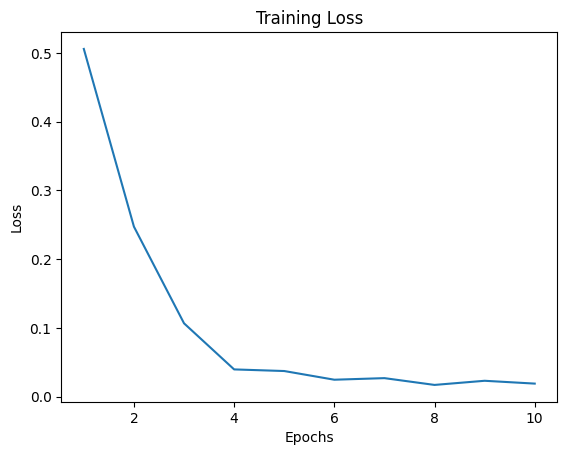

In [7]:
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

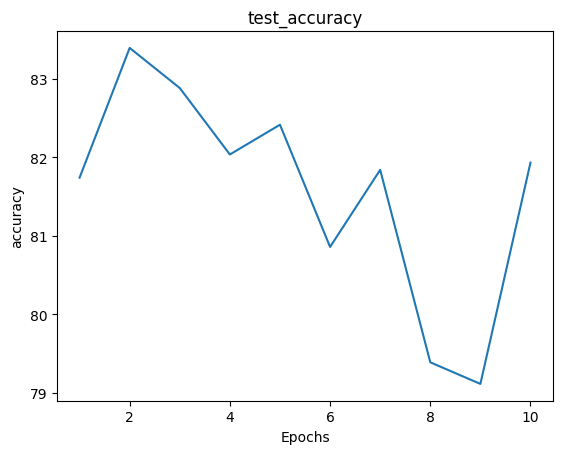

epoch:1,test accuracy:81.74152813299233
epoch:2,test accuracy:83.39593989769821
epoch:3,test accuracy:82.88443094629156
epoch:4,test accuracy:82.03724424552429
epoch:5,test accuracy:82.41687979539643
epoch:6,test accuracy:80.85837595907928
epoch:7,test accuracy:81.84143222506394
epoch:8,test accuracy:79.38778772378517
epoch:9,test accuracy:79.11205242966751
epoch:10,test accuracy:81.93334398976982


In [8]:
plt.plot(epochs, test_accuracies)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('test_accuracy')
plt.show()
for e in epochs:
    print("epoch:{},test accuracy:{}".format(e,test_accuracies[e-1]))

In [9]:
testmodel = SelfAttention(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)

testmodel.load_state_dict(torch.load('models/best_self_Attention.pth'))
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen1 = TEXT.preprocess(test_sen1)
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]
test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")

/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Sentiment: Positive
